# Frozen Lake Testing

Short notebook just playing around with the Frozen Lake environment to get a feel for it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from crl.envs.frozen_lake import make_env
from crl.utils.graphing import get_robust_perf_stats, plot_robust_perf_curve, despine
from crl.predictors.tabular import PredictorGlobal, PredictorSAConditioned, NoPredictor
from crl.agents.tabular.dyna import DynaVAgent, DynaAgentParams, Reward
from crl.agents.tabular.adaptive import AdaptiveLearningAgent, AdaptiveAgentParams
from tqdm import trange

## Define a tabular agent to solve the env for a fixed map

Using a value-function based Dyna setup

S <- current state\
A <- epsilon-greedy V(s') for all possible actions\
receive S', R\
Model(S, A, S') <- (running average)\
Loop:\
&nbsp;&nbsp;&nbsp;&nbsp;S <- random previously observed state\
&nbsp;&nbsp;&nbsp;&nbsp;A <- random previously taken action\
&nbsp;&nbsp;&nbsp;&nbsp;R, S' <- sample from Model(S, A)\
&nbsp;&nbsp;&nbsp;&nbsp;V(s) = V(s) + alpha [R + gamma V(s') - V(s)]

In [12]:
def train_agent(
    slip_prob: float = 0.15,
    n_episodes: int = 3_000,
    epsilon_init: float = 1.0,
    rng: int = 42,
    lr: float = 0.1,
    alpha: float = 0.2,
    start_cp: int = 1_500,
    max_epsiode_steps: int = 1_000,
) -> tuple[DynaVAgent, list['Reward'], list[bool]]:
    # setup env
    env = make_env(seed=rng, slip_prob=slip_prob, max_episode_steps=max_epsiode_steps)()

    # setup agent
    predictor = PredictorSAConditioned(n_states=16, n_actions=4, alpha=alpha, n_calib=100, min_count=50)
    # predictor = PredictorGlobal(alpha=alpha, n_calib=400)
    # params = DynaAgentParams(
    #     learning_rate=lr, epsilon=epsilon_init, discount=0.99, rng=rng
    # )
    # agent = DynaVAgent(env, params, predictor)
    params = AdaptiveAgentParams(learning_rate=lr, epsilon=epsilon_init, use_predictor=True, n_plan_steps=0, discount=0.99, rng=rng)
    agent = AdaptiveLearningAgent(env, params, predictor)

    # train the agent
    returns = []
    falls = []
    for episode in range(n_episodes):
        # simple epsilon schedule encourages heavy exploration early - linearly decays to 0 by the halfway mark
        if episode > 0:
            agent.epsilon = max(0, epsilon_init * (1 - (episode - 0) / (2_000 // 2)))
        
        # option to ignore conformal prediction during early learning
        if episode > start_cp:
            agent.use_predictor = True

        done = False
        state, info = env.reset()
        while not done:
            # execute an action to interact with the MDP
            action = agent.select_action(state)
            state_next, reward, terminated, truncated, info = env.step(action)
            obs = (state, action, reward, state_next)
            agent.observe(obs)
            state = state_next

            # By default there's no planning happen - it complicates things
            agent.plan()

            done = terminated or truncated
            if done:
                returns.append(reward)
                if terminated and reward == 0:
                    agent_fell = True
                else:
                    agent_fell = False
                falls.append(agent_fell)

    return agent, returns, falls


In [13]:
from joblib import Parallel, delayed
from tqdm import tqdm


# Define the function to be parallelized
def run_single_experiment(
    slip_prob: float,
    seed: int,
    alpha: float = 0.2,
    start_cp: int = 1_500,
    max_episode_steps: int = 100,
) -> tuple[DynaVAgent, list['Reward'], list[bool]]:
    # This function should contain the logic for one run
    # Note: It's often better to instantiate the agent and env inside
    # the worker process to avoid pickling issues.
    agent, exp_returns, falls = train_agent(
        slip_prob=slip_prob,
        rng=seed,
        alpha=alpha,
        start_cp=start_cp,
        max_epsiode_steps=max_episode_steps,
    )
    return agent, exp_returns, falls


# Main loop
n_runs = 50
SLIP_PROBS = [0.0, 0.15, 0.6]
all_returns = {sp: [] for sp in SLIP_PROBS}
agents = {}
falls = {sp: [] for sp in SLIP_PROBS}
cp_start_episode = 1_500
alpha = 0.01
for slip_prob in (pbar := tqdm(all_returns)):
    pbar.set_description(f"Running Experiment: p={slip_prob}")
    tasks = (
        delayed(run_single_experiment)(
            slip_prob, run, alpha=alpha, start_cp=cp_start_episode, max_episode_steps=500
        )
        for run in range(n_runs)
    )

    # Wrap the Parallel object, which is a generator of results
    results = Parallel(n_jobs=-1)(tasks)
    all_returns[slip_prob] = [res[1] for res in results]
    falls[slip_prob] = [res[2] for res in results]

    # save an agent from each run to play around with
    agents[slip_prob] = results[0][0]

Running Experiment: p=0.6: 100%|██████████| 3/3 [00:40<00:00, 13.41s/it] 


100%|██████████| 2000/2000 [00:01<00:00, 1064.26it/s]


Slip prob: 0.00, Last 100 eps IQM: 1.000
Slip prob: 0.15, Last 100 eps IQM: 0.991
Slip prob: 0.60, Last 100 eps IQM: 0.864


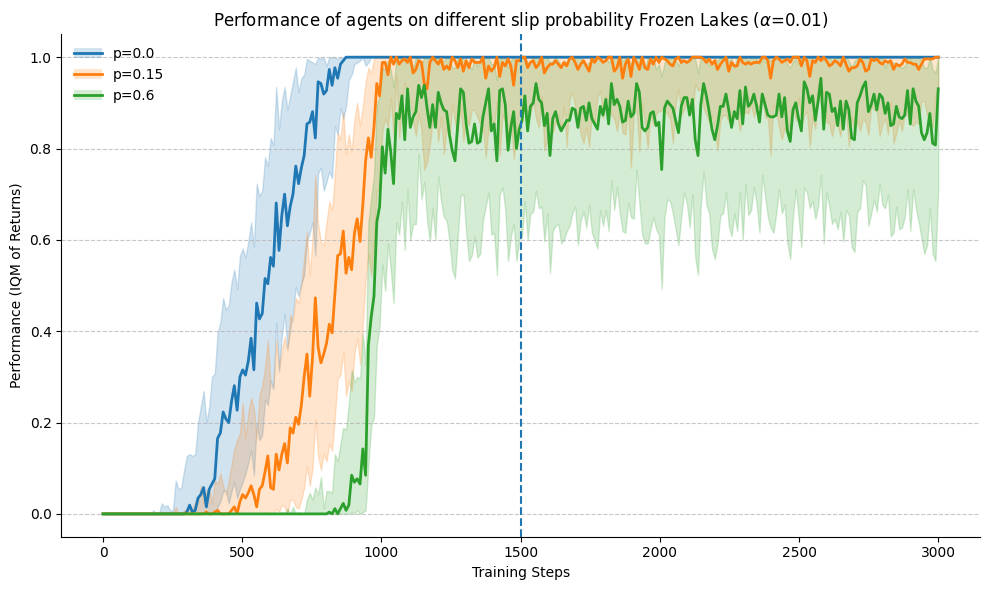

In [14]:
from matplotlib.legend_handler import HandlerTuple

fig, ax = plt.subplots(figsize=(10, 6))
legend_handles = []
legend_labels = []
metrics = {}
cp_returns_hist = {}
no_cp_returns_hist = {}

for ix, slip_prob in enumerate(SLIP_PROBS):
    exp_returns = np.array(all_returns[slip_prob])
    stats = get_robust_perf_stats(exp_returns, n_bootstrap_samples=2000, pbar=True)
    handle, label = plot_robust_perf_curve(
        ax, stats, label=f"p={slip_prob}", color=f"C{ix}", smooth=10
    )
    legend_handles.append(handle)
    legend_labels.append(label)

    metrics[slip_prob] = stats['iqm'][-100:].mean()
    cp_returns_hist[slip_prob] = exp_returns[:, -100:].mean(1)
    no_cp_returns_hist[slip_prob] = exp_returns[:, 1_400:1_500].mean(1)



for slip_prob, asym_return in metrics.items():
    print(f'Slip prob: {slip_prob:.2f}, Last 100 eps IQM: {asym_return:0.3f}')


despine(ax)
ax.set_title(fr"Performance of agents on different slip probability Frozen Lakes ($\alpha$={alpha})")
ax.set_xlabel("Training Steps")
ax.set_ylabel("Performance (IQM of Returns)")
ax.legend(
    legend_handles,
    legend_labels,
    handler_map={tuple: HandlerTuple(ndivide=1, pad=0)},
    frameon=False,
    loc="best",
)
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.axvline(x=cp_start_episode, linestyle='--')
plt.tight_layout()
plt.show()

In [15]:
agent = agents[0.15]
# plot_grid(agent.V)

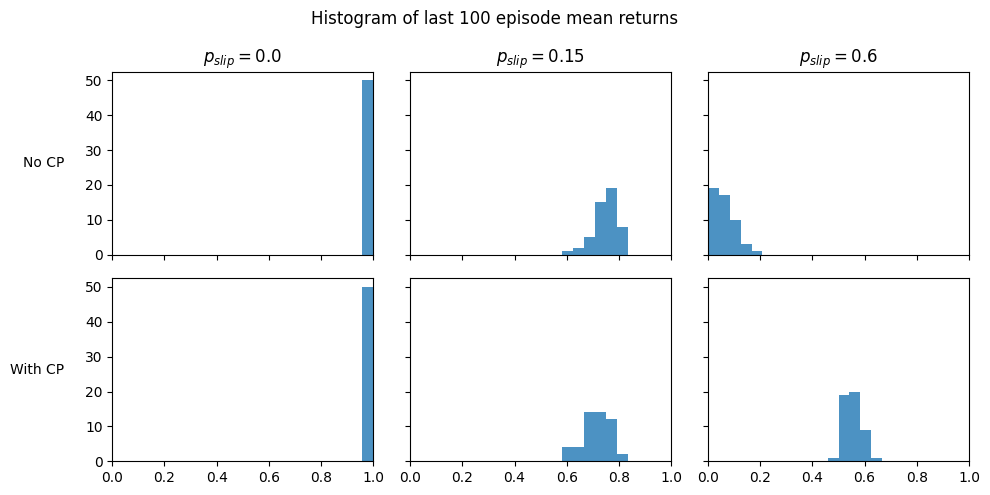

In [24]:
bins = np.linspace(0, 1, 25)

fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(10, 5))


# Plot No CP returns
axes[0, 0].hist(no_cp_returns_hist[0.0], bins=bins, alpha=0.8)
axes[0, 1].hist(no_cp_returns_hist[0.15], bins=bins, alpha=0.8)
axes[0, 2].hist(no_cp_returns_hist[0.6], bins=bins, alpha=0.8)

# Plot CP returns
axes[1, 0].hist(cp_returns_hist[0.0], bins=bins, alpha=0.8)
axes[1, 1].hist(cp_returns_hist[0.15], bins=bins, alpha=0.8)
axes[1, 2].hist(cp_returns_hist[0.6], bins=bins, alpha=0.8)

# Optional: enforce identical limits explicitly (sharex/sharey already sync them)
axes[1, 0].set_xlim(bins[0], bins[-1])
axes[1, 0].set_ylim(bottom=0)

# Add labels
axes[0, 0].set_ylabel("No CP", rotation=0, labelpad=15, ha="right", va="center")
axes[1, 0].set_ylabel("With CP", rotation=0, labelpad=15, ha="right", va="center")
axes[0, 0].set_title(r"$p_{slip}=0.0$")
axes[0, 1].set_title(r"$p_{slip}=0.15$")
axes[0, 2].set_title(r"$p_{slip}=0.6$")

fig.suptitle("Histogram of last 100 episode mean returns")
plt.tight_layout()
plt.show()

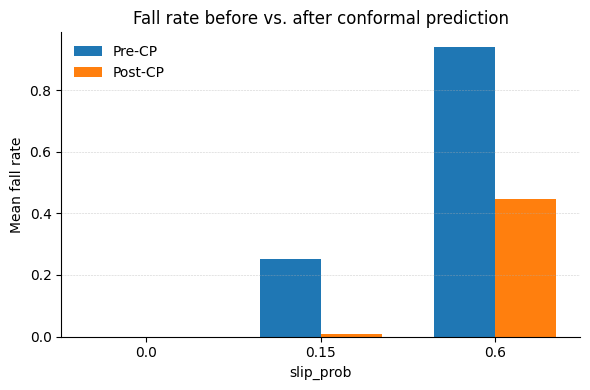

In [25]:
# last 100 episode results before CP
pre_start = 1_400
pre_end = 1_500

post_start = 2_900
post_end = 3_000

# --- gather the two series you want to plot ----------------------------------
means_pre  = []
means_post = []

for slip_prob in SLIP_PROBS:
    arr = np.asarray(falls[slip_prob])          # shape: (runs, episodes)
    means_pre.append( arr[:, pre_start : pre_end ].mean() )
    means_post.append( arr[:, post_start: post_end].mean() )

means_pre  = np.array(means_pre)
means_post = np.array(means_post)

# --- grouped-bar plot ---------------------------------------------------------
x        = np.arange(len(SLIP_PROBS))       # the bar centers
width    = 0.35                              # bar width

fig, ax  = plt.subplots(figsize=(6, 4))
ax.bar(x - width/2, means_pre,  width, label="Pre-CP")
ax.bar(x + width/2, means_post, width, label="Post-CP")

# cosmetic touches
ax.set_xticks(x)
ax.set_xticklabels(SLIP_PROBS)
ax.set_ylabel("Mean fall rate")
ax.set_xlabel("slip_prob")
ax.set_title("Fall rate before vs. after conformal prediction")
ax.legend(frameon=False)
ax.grid(axis="y", linestyle="--", linewidth=0.4, alpha=0.6)
despine(ax)
plt.tight_layout()
plt.show()

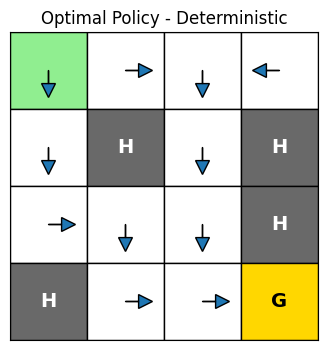

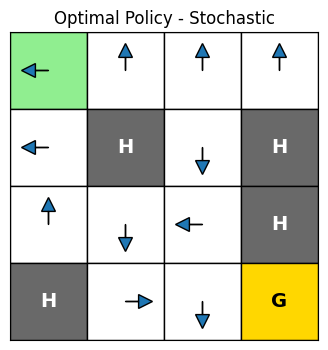

In [103]:
# D R D L
# D H D H
# R D D H
# H R R G

# Optimal Policy: Deterministic
# Grid layout: each symbol represents the policy or special cell
grid_deterministic = [
    ['D', 'R', 'D', 'L'],
    ['D', 'H', 'D', 'H'],
    ['R', 'D', 'D', 'H'],
    ['H', 'R', 'R', 'G']
]

grid_stochastic = [
    ['L', 'U', 'U', 'U'],
    ['L', 'H', 'D', 'H'],
    ['U', 'D', 'L', 'H'],
    ['H', 'R', 'D', 'G']
]

def plot_policy(grid, title):
    nrows, ncols = len(grid), len(grid[0])

    fig, ax = plt.subplots(figsize=(ncols, nrows))

# Define arrow offsets for each direction
    arrow_offsets = {
    'U': (0, 0.4, 0, 0.35),
    'D': (0, -0.4, 0, -0.35),
    'L': (-0.4, 0, -0.35, 0),
    'R': (0.4, 0, 0.35, 0),
}

# Loop over the grid and draw each cell
    for i in range(nrows):
        for j in range(ncols):
            symbol = grid[i][j]
        
        # Calculate the bottom‑left corner of the cell
            x, y = j, nrows - 1 - i  # invert y‑axis so row 0 is at the top

        # Determine cell facecolor
            if (i, j) == (0, 0):            # Start state (top‑left)
                facecolor = 'lightgreen'
            elif symbol == 'H':             # Hole
                facecolor = 'dimgray'
            elif symbol == 'G':             # Goal
                facecolor = 'gold'
            else:
                facecolor = 'white'
        
        # Draw the cell rectangle
            ax.add_patch(plt.Rectangle((x, y), 1, 1, facecolor=facecolor, edgecolor='black'))
        
        # Add arrow or text
            if symbol in arrow_offsets:
                dx, dy, dx_head, dy_head = arrow_offsets[symbol]
                ax.arrow(x + 0.5, y + 0.5, dx_head, dy_head,
                     head_width=0.18, head_length=0.18, length_includes_head=True)
            elif symbol == 'H':
                ax.text(x + 0.5, y + 0.5, 'H', ha='center', va='center', color='white', fontsize=14, weight='bold')
            elif symbol == 'G':
                ax.text(x + 0.5, y + 0.5, 'G', ha='center', va='center', color='black', fontsize=14, weight='bold')

# Aesthetics
    ax.set_xlim(0, ncols)
    ax.set_ylim(0, nrows)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    ax.set_title(title)

    plt.show()

plot_policy(grid_deterministic, title = "Optimal Policy - Deterministic")
plot_policy(grid_stochastic, title = "Optimal Policy - Stochastic")

In [8]:
p_slip = 0.1              # chance of slipping to a perpendicular action


def generate_true_model(p_slip):
    grid = np.array([
    list("SFFF"),
    list("FHFH"),
    list("FFFH"),
    list("HFFG")
])

    nS, nA = grid.size, 4                  # 16 states, 4 actions
    M = np.zeros((nS, nA, nS))

    dirs  = {0: (-1, 0), 1: (0, 1), 2: (1, 0), 3: (0, -1)}      # up, right, down, left
    perp  = {0: (3, 1), 1: (0, 2), 2: (3, 1), 3: (0, 2)}        # perpendicular pairs

    to_state = lambda r, c: 4*r + c

    for r in range(4):
        for c in range(4):
            s = to_state(r, c)

        # holes and goal are absorbing
            if grid[r, c] in "HG":
                M[s, :, s] = 1.0
                continue

            for a in range(nA):
                for p, act in ((1 - p_slip, a),
                           (p_slip / 2, perp[a][0]),
                           (p_slip / 2, perp[a][1])):
                    dr, dc = dirs[act]
                    nr, nc = r + dr, c + dc
                    ns = to_state(nr, nc) if 0 <= nr < 4 and 0 <= nc < 4 else s
                    M[s, a, ns] += p
    
    return grid

generate_true_model(p_slip)

array([['S', 'F', 'F', 'F'],
       ['F', 'H', 'F', 'H'],
       ['F', 'F', 'F', 'H'],
       ['H', 'F', 'F', 'G']], dtype='<U1')

In [56]:
np.array(falls[0.0]).shape

(50, 3000)

In [6]:
ACTION_MAP = {
    'left': 0, 'down': 1, 'right': 2, 'up': 3
}

# # preds: np.ndarray, state: "State", action: "Action"
# state = 0
# action = ACTION_MAP['right']
# preds = agent.world_model[state, action]
# agent.predictor.conformalise(preds, state, action)
# # agent.predictor.conformalise(np.array([]), state=0, action=ACTION_MAP['right'])

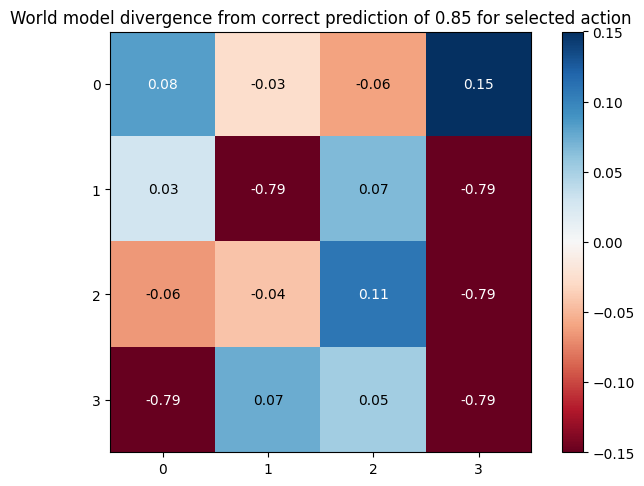

In [6]:
def plot_grid(vals: np.ndarray, vmin = None, vmax = None, cbar=True):
    vals_reshaped = vals.reshape((4, 4))

    fig, ax = plt.subplots()
    im = ax.imshow(vals_reshaped, cmap="RdBu", vmin=vmin, vmax=vmax)

    if cbar:
        plt.colorbar(im)
    # Put the value annotations back in
    for i in range(vals_reshaped.shape[0]):
        for j in range(vals_reshaped.shape[1]):
            ax.text(j, i,
                    f"{vals_reshaped[i, j]:.2f}",
                    ha="center", va="center",
                    color="white" if np.abs(vals_reshaped[i, j]) > np.median(np.abs(vals_reshaped)) else "black")

    # --- NEW: integer ticks 0-3 on both axes ---
    ax.set_xticks(np.arange(4))
    ax.set_yticks(np.arange(4))
    ax.set_xticklabels(np.arange(4))
    ax.set_yticklabels(np.arange(4))

    plt.tight_layout()
    return fig

# In a calibrated world model the max for each state-action pair should
# be ,in principle, 0.85 - the true chance of not slipping
divergences_sa = agent.world_model.max(axis=2) - 0.85
divergences_sa = divergences_sa[range(16), np.abs(divergences_sa).argmax(axis=1)] # get the max divergence per state
fig = plot_grid(divergences_sa, vmin=-0.15, vmax=0.15)
plt.title(f'World model divergence from correct prediction of 0.85 for selected action')
plt.show()
# plot_grid(agent.V)

In [105]:
state = 4
action = ACTION_MAP['down']

preds = agent.world_model[state, action]
pred_set = agent.predictor.conformalise(preds, state, action)
pred_set

[4, 8]

In [6]:
returns = np.array(returns)
plt.plot(returns.reshape(-1, 100).mean(1))

NameError: name 'returns' is not defined

In [ ]:
# eval
agent.epsilon = 0.0

eval_returns = []
for episode in trange(1_000):
    done = False
    state, info = env.reset()
    while not done:
        action = agent.select_action(state)
        state_next, reward, terminated, truncated, info = env.step(action)
        state = state_next

        done = terminated or truncated
        if done:
            eval_returns.append(reward)

100%|██████████| 1000/1000 [00:00<00:00, 9108.37it/s]


In [ ]:
# plt.plot(eval_returns)
np.mean(eval_returns)

np.float64(0.718)

In [ ]:
agent.reward_model[-2]

array([0., 1., 0., 0.])